In [8]:
import numpy as np
import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pdist
import matplotlib.pyplot as plt

In [2]:
import os
import sys
import inspect

# insert root dir into sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root_dir = os.path.dirname(currentdir)
# print(root_dir)

if root_dir not in sys.path:
     sys.path.insert(0, root_dir)

### Model 1 description:

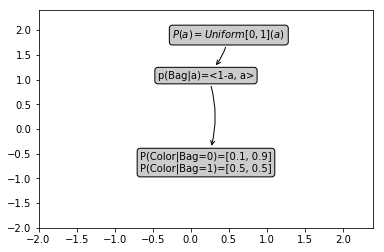

In [32]:

bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="<-")

fig, (ax1) = plt.subplots(1, 1)

an1 = ax1.annotate('$P(a)=Uniform[0,1](a)$', xy=(.5, 1.9), xycoords='data',
                   xytext=(.5, 1.9), textcoords='data',
                   ha="center", va="center",
                   bbox=bbox_args,
                   #arrowprops=arrow_args
                   )

an2 = ax1.annotate('p(Bag|a)=<1-a, a>', xy=(.5, .7), xycoords=an1,
                   xytext=(.5, .7), textcoords='axes fraction',
                   ha="center", va="center",
                   bbox=bbox_args,
                   arrowprops=dict(patchB=an1.get_bbox_patch(),
                                   connectionstyle="arc3,rad=0.2",
                                   **arrow_args))

an3 = ax1.annotate('P(Color|Bag=0)=[0.1, 0.9]\nP(Color|Bag=1)=[0.5, 0.5]', xy=(.5, .3), xycoords=an2,
                   xytext=(.5, .3), textcoords='axes fraction',
                   ha="center", va="center",
                   bbox=bbox_args,
                   arrowprops=dict(patchB=an2.get_bbox_patch(),
                                   connectionstyle="arc3,rad=0.2",
                                   **arrow_args))
ax1.set_xlim([-2, 2.4])
ax1.set_ylim([-2, 2.4])

# an1.draggable()

plt.show()

### Accurate inference:

$P(Color \ |\ a\geq 0.7)=\frac{P(Color,\ a \geq0.7)}{P(a \geq 0.7)}=\frac{P(Color,\ a \geq0.7)}{P(a \geq 0.7)}=\frac{\sum_{b}P(Color, \ Box=b,\ a \geq 0.7)}{P(a \geq 0.7)}
$
<br><br>
$=\frac{\sum_{b}P(Color \ |\ Box=b)P(Box=b,\ a \geq 0.7)}{P(a \geq 0.7)}=
\frac{\sum_{b}P(Color \ |\ Box=b)\int_{a \geq 0.7}P(Box=b \ |a)P(d a)}{P(a \geq 0.7)}
$
<br><br>
$= \frac{\sum_{b}P(Color \ |\ Box=b)\int_{a \geq 0.7}p(Box=b \ |\ a)u(a)d a}{P(a \geq 0.7)}=\frac{\sum_{b}P(Color \ |\ Box=b)\int_{a \geq 0.7}p(Box=b \ |\ a)d a}{P(a \geq 0.7)}=$
<br><br>

<br>
$\frac{P(Color \ |\ Box=0)\int_{a \geq 0.7}p(Box=0\ |\ a)d a}{\int{a \geq 0.7}d a}
+\frac{P(Color\ |\ Box=1)\int_{a \geq 0.7}p(Box=1\ |\ a)d a}{\int{a \geq 0.7}d a}
=\frac{<0.1,\ 0.9>\int_{a \geq 0.7} (1-a)d a+<0.5,\ 0.5>\int_{a \geq 0.7 } a d a}{\int{a \geq 0.7}d a}=\frac{<0.1,\ 0.9>(0.045)+<0.5,\ 0.5>(0.255)}{0.3}$
<br>
$ = <0.44, 0.56>$

$P(Box\ |\ a \geq 0.7)=\frac{\int_{a \geq 0.7}p(Box\ |\ a)d a}{\int_{a \geq 0.7} d a}=<0.045, 0.255>/0.3= <0.15, 0.85>$

### Native `rejection_sampler`:

In [35]:
import sim1

##### Model's def:

In [44]:
a = sim1.make_dist(dist.Uniform, "a", 0, 1) 

# P(Bag==1) = a (P(Bag==1) = 1-a):
Bag = sim1.CondProb("Bag", parents=["a"], support=[[0, 1], ["a"]],
                    params=[("Bag==1", "a")])
    
# P(Color|Bag):
Color = sim1.CondProb("Color", parents=["Bag"],
                      support=[["red", "green"], [0, 1]])
Color.set({"Bag": 0}, [0.1, 0.9])
Color.set({"Bag": 1}, [0.5, 0.5])

net = sim1.BayesNet([a, Bag, Color])

print("net.sorted_vars:")
print(net.sorted_vars)
print("\nColor:")
print(Color)

net.sorted_vars:
['a', 'Bag', 'Color']

Color:
             0
Color Bag     
red   0    0.1
      1    0.5
green 0    0.9
      1    0.5


In [56]:
samples, indexes, labels = sim1.rejection_sampling(net, 700,
                                              cond="$a>=0.7")

progress: █████████ 99 %
done


##### Results:

len(samples)
230
var:
Bag
probs of var (bin=2):
tensor([0.1652, 0.8348], dtype=torch.float64)


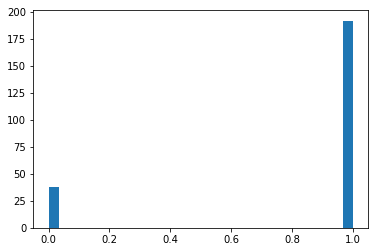

In [58]:
print("len(samples)")
print(len(samples['Bag']))
# print(indexes)
# print(labels)

sim1.plot_results1(["Bag"], indexes)

### Pyro's `rejection_sampler`:

In [5]:
import sim3

In [3]:
def model1():
    '''
    Model:
    {a| a=Uniform(0, 1)}
      ->{Bag| [p(Bug=0)=1-a, p(Bug=1)=a]}
       ->{Color| [p(Color|"Bag": 0)=[0.1, 0.9],
                  p(Color|"Bag": 1) = [0.5, 0.5]]}
    Ask what p(X|cond) will be for X is some of [a, Bag, Color]
    '''
    p = pyro.sample("p", pdist.Uniform(0, 1))
    # p(Bag|p) (note probability reverse in Categorical!):
    bag = pyro.sample("Bag", pdist.Categorical(torch.tensor([1-p, p])))
    pColor = torch.tensor([[0.1, 0.9], [0.5, 0.5]])
    color = pyro.sample("Color", pdist.Categorical(pColor[bag.type(torch.long)]))
    return(color)


def m1_fcond(trace):
    return(trace.nodes['p']['value'] >= 0.7)

In [6]:
pyro.clear_param_store()
samples = sim3.rejection_sampling(model1, {}, m1_fcond, 10000)
df = sim3.make_dataFrame(samples)

progress: █████████ 99 %
done
create df:: █████████ 99 %
done


probs of var (bin=2):
tensor([0.4399, 0.5601], dtype=torch.float64)


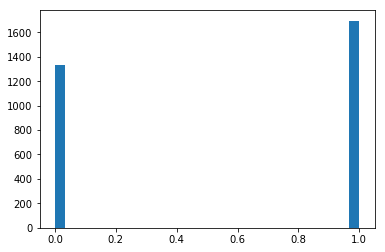

In [9]:
var_data = df["Color"].to_numpy().astype(np.float)
print("probs of var (bin=2):")
var_data = torch.histc(torch.tensor(var_data), 2) 
print(var_data/var_data.sum())

plt.hist(df["Color"].to_numpy(), 30,  # density=True,
        stacked=True
        # , rwidth=0.1, label=label
        )
plt.show()


probs of var (bin=2):
tensor([0.1553, 0.8447], dtype=torch.float64)


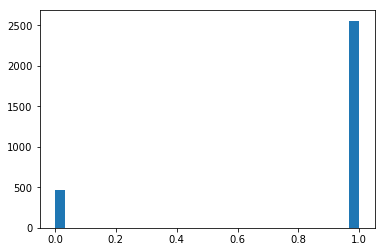

In [10]:
var_data = df["Bag"].to_numpy().astype(np.float)
print("probs of var (bin=2):")
var_data = torch.histc(torch.tensor(var_data), 2) 
print(var_data/var_data.sum())

plt.hist(df["Bag"].to_numpy(), 30,  # density=True,
        stacked=True
        # , rwidth=0.1, label=label
        )
plt.show()
